In [1]:
import warnings
# Suppress specific FutureWarning from pandas about swapaxes
warnings.filterwarnings("ignore", category=FutureWarning, message=".*DataFrame.swapaxes.*")

import kagglehub
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load and preprocess metadata
path = kagglehub.dataset_download("patrickfleith/nasa-battery-dataset")
metadata_path = os.path.join(path, "cleaned_dataset", "metadata.csv")
metadata = pd.read_csv(metadata_path)
metadata['battery_id'] = metadata['battery_id'].astype(str)

# Exclude problematic batteries
excluded_batteries = ['B0049', 'B0050', 'B0051', 'B0052']

# Filter to only discharge cycles, excluding the listed batteries
discharge_metadata = metadata[
    (metadata['type'] == 'discharge') & 
    (~metadata['battery_id'].isin(excluded_batteries))
].copy()

# Assign a sequential cycle number per battery
discharge_metadata['cycle_number'] = discharge_metadata.groupby('battery_id').cumcount() + 1

processed_dfs = []

# Process each discharge cycle
for _, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
    file_path = f"{path}/cleaned_dataset/data/{row['filename']}"
    df = pd.read_csv(file_path).copy()
    
    # Truncate data at the first point where voltage < 2.7V
    cutoff_idx = df[df['Voltage_measured'] < 2.7].index.min()
    truncated_df = df if pd.isna(cutoff_idx) else df.iloc[:cutoff_idx].copy()
    
    # Compute capacity using coulomb counting (sum of current over time)
    truncated_df['Time_diff_hr'] = truncated_df['Time'].diff().fillna(0) / 3600
    truncated_df['Delta_Q'] = truncated_df['Current_measured'] * truncated_df['Time_diff_hr']
    capacity = abs(truncated_df['Delta_Q'].sum())
    
    # Only use cycles with capacity above threshold (filter out bad data)
    if capacity > 1.4:
        # Add battery and cycle info columns
        truncated_df['battery_id'] = row['battery_id']
        truncated_df['cycle_number'] = row['cycle_number']
        # Calculate SoC using coulomb counting
        truncated_df['Cumulative_Q'] = truncated_df['Delta_Q'].cumsum()
        truncated_df['SoC'] = 100 * (1 + truncated_df['Cumulative_Q'] / capacity)
        # Calculate SoH as percentage of nominal capacity (2.0 Ah)
        soh_value = (capacity / 2.0) * 100
        truncated_df['SoH'] = soh_value
        
        # Downsample each cycle to 20 bins by averaging (for uniform length)
        num_bins = 10
        bins = np.array_split(truncated_df, num_bins)
        agg_rows = []
        for b in bins:
            if b.empty:
                continue
            avg_voltage = b['Voltage_measured'].mean()
            avg_current = b['Current_measured'].mean()
            avg_temp = b['Temperature_measured'].mean()
            avg_soc = b['SoC'].mean()
            agg_rows.append({
                'Voltage_measured': avg_voltage,
                'Current_measured': avg_current,
                'Temperature_measured': avg_temp,
                'SoC': avg_soc,
                'cycle_number': b['cycle_number'].iloc[0],
                'battery_id': b['battery_id'].iloc[0],
                'SoH': b['SoH'].iloc[0]
            })
        cycle_df = pd.DataFrame(agg_rows)
        # Only accept cycles that yield exactly 20 bins
        if len(cycle_df) != num_bins:
            continue
        processed_dfs.append(cycle_df)

# Concatenate all cycles and save as new CSV
if processed_dfs:
    full_dataset = pd.concat(processed_dfs)
    print(f"Final dataset shape: {full_dataset.shape}")
    full_dataset.to_csv("battery_health_dataset.csv", index=False)

/home/andrea/andrea/iot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2694/2694 [00:03<00:00, 758.75it/s]


Final dataset shape: (14590, 7)


In [2]:
# Shared setup: loads CSV, builds grouped split, scaling, and metrics helpers
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reproducibility
SEED = 21
np.random.seed(SEED)
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load preprocessed 20-bin CSV produced by your script
df = pd.read_csv("battery_health_dataset.csv")
# confirm structure: (every cycle produced 20 rows)
print("Dataset rows,cols:", df.shape)
print(df.columns.tolist())

# We'll build sequence windows per cycle by grouping cycle (there should be 20 rows per cycle)
# Convert to sequences: one sequence per cycle (shape: num_cycles, 20, features)
features = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'SoC']
grouped = df.groupby(['battery_id', 'cycle_number'])
seqs = []
soh = []
groups = []
cycle_index = []  # optional: normalized cycle number per battery
for (bid, cyc), g in grouped:
    g_sorted = g.sort_index()  # already aligned by your binning
    if len(g_sorted) != 10:
        continue
    seqs.append(g_sorted[features].values.astype(np.float32))  # (20,4)
    soh.append(g_sorted['SoH'].iloc[0])
    groups.append(bid)
    cycle_index.append(g_sorted['cycle_number'].iloc[0])

X_seq = np.stack(seqs)  # (N_cycles, 20, 4)
y = np.array(soh).astype(np.float32)
groups = np.array(groups)
cycle_index = np.array(cycle_index).astype(np.float32)

print("Sequences shape:", X_seq.shape, "Targets shape:", y.shape, "Unique batteries:", np.unique(groups).shape)

# Grouped split: holdout batteries for testing (ensures no leakage)
unique_batts = np.unique(groups)
train_batts, test_batts = train_test_split(unique_batts, test_size=0.20, random_state=SEED, shuffle=False)
train_mask = np.isin(groups, train_batts)
test_mask = np.isin(groups, test_batts)

X_seq_train = X_seq[train_mask]; X_seq_test = X_seq[test_mask]
y_train = y[train_mask]; y_test = y[test_mask]
cycle_index_train = cycle_index[train_mask]; cycle_index_test = cycle_index[test_mask]

# Flattened versions for non-sequence models if needed
X_flat_train = X_seq_train.reshape((X_seq_train.shape[0], -1))
X_flat_test  = X_seq_test.reshape((X_seq_test.shape[0], -1))

# Scale: fit scalers only on train
scaler_flat = StandardScaler().fit(X_flat_train)
X_flat_train_s = scaler_flat.transform(X_flat_train)
X_flat_test_s = scaler_flat.transform(X_flat_test)

# For sequence models, scale per feature across all time positions using train data
n_features = X_seq_train.shape[2]
X_seq_train_2d = X_seq_train.reshape(-1, n_features)
scaler_seq = StandardScaler().fit(X_seq_train_2d)
def scale_seq(X):
    s = X.reshape(-1, n_features)
    s = scaler_seq.transform(s)
    return s.reshape(X.shape)
X_seq_train_s = scale_seq(X_seq_train)
X_seq_test_s  = scale_seq(X_seq_test)

# Define tolerance-based "accuracy" for regression: prediction within tol_pct percent of true SoH.
def tolerance_accuracy(y_true, y_pred, tol_pct=2.0):
    # tol_pct is percent (e.g., 2.0 means ±2% absolute SoH)
    tol = tol_pct
    correct = np.abs(y_true - y_pred) <= tol
    return float(np.mean(correct))

def print_metrics(y_true, y_pred, tol_pct=2.0):
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2:", r2_score(y_true, y_pred))
    print(f"Accuracy within ±{tol_pct}%:", tolerance_accuracy(y_true, y_pred, tol_pct))

print("Train/test sizes:", X_seq_train_s.shape, X_seq_test_s.shape)


Dataset rows,cols: (14590, 7)
['Voltage_measured', 'Current_measured', 'Temperature_measured', 'SoC', 'cycle_number', 'battery_id', 'SoH']
Sequences shape: (1459, 10, 4) Targets shape: (1459,) Unique batteries: (24,)
Train/test sizes: (1313, 10, 4) (146, 10, 4)


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def plot_history(history, title="Training vs Validation Loss"):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual SoH")
    plt.ylabel("Predicted SoH")
    plt.title(title)
    plt.grid()
    plt.show()


def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("Prediction Error (SoH)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


def plot_soh_trend(y_true, y_pred, title, n=200):
    plt.figure(figsize=(10,4))
    plt.plot(y_true[:n], label="Actual")
    plt.plot(y_pred[:n], label="Predicted")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("SoH")
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
window_size = X_seq_train_s.shape[1]       
n_features   = X_seq_train_s.shape[2]
print(window_size,n_features)

10 4


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np

# Calcolo dimensione input piatto
input_flat_dim = window_size * n_features

# Reshape manuale (Flattening)
X_train_flat = X_seq_train_s.reshape(X_seq_train_s.shape[0], -1)
X_test_flat = X_seq_test_s.reshape(X_seq_test_s.shape[0], -1)

print(f"Shape originale: {X_seq_train_s.shape}")
print(f"Shape appiattita per emlearn: {X_train_flat.shape}")

# --- 2. BUILD MODEL (Dense MLP ottimizzato per nRF52840) ---
def build_emlearn_model(input_dim):
    # Architettura TINY per microcontrollori (nRF52840: 64KB RAM, 1MB Flash)
    # Modello compatto per predizione SoH: input_dim -> 16 -> 8 -> 1
    model = models.Sequential([
        # Primo strato Dense
        layers.Dense(16, activation='relu', input_dim=input_dim),
        
        # Secondo strato Dense
        layers.Dense(8, activation='relu'),

        # Output Layer (Regressione lineare per predire SoH)
        layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_emlearn_model(input_flat_dim)
model.summary()

# Stima dimensione modello
total_params = model.count_params()
estimated_size_kb = (total_params * 4) / 1024  # 4 bytes per parametro (float32)
print(f"\n=== DIMENSIONI MODELLO ===")
print(f"Parametri totali: {total_params}")
print(f"Dimensione stimata: ~{estimated_size_kb:.1f} KB (con float32)")

Shape originale: (1313, 10, 4)
Shape appiattita per emlearn: (1313, 40)


/home/andrea/andrea/iot/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)


=== DIMENSIONI MODELLO ===
Parametri totali: 801
Dimensione stimata: ~3.1 KB (con float32)


In [6]:
history = model.fit(
    X_train_flat, y_train,
    validation_data=(X_test_flat, y_test),
    epochs=120, 
    batch_size=64,
    # EarlyStopping per fermarsi se non migliora più
    callbacks=[callbacks.EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1,
    shuffle=False # FONDAMENTALE: False per mantenere l'ordine temporale del degrado
)

Epoch 1/120


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6831.0679 - mae: 82.3582 - val_loss: 5385.5640 - val_mae: 73.2475
Epoch 2/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6666.4160 - mae: 81.3530 - val_loss: 5213.1318 - val_mae: 72.0486
Epoch 3/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6485.0054 - mae: 80.2340 - val_loss: 4989.6040 - val_mae: 70.4621
Epoch 4/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6270.3164 - mae: 78.8852 - val_loss: 4704.4038 - val_mae: 68.3800
Epoch 5/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6003.0854 - mae: 77.1720 - val_loss: 4349.0522 - val_mae: 65.6880
Epoch 6/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5664.9473 - mae: 74.9448 - val_loss: 3919.4277 - val_mae: 62.2697
Epoch 7/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5245.9067 - mae: 72.0851 - val_loss: 3418.6672 - val_mae: 58.0188
Epoch 8/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4737.7822 - mae: 68.4510 - val_loss: 2861.1448 - val_mae: 52.8686
Epoch 9/120


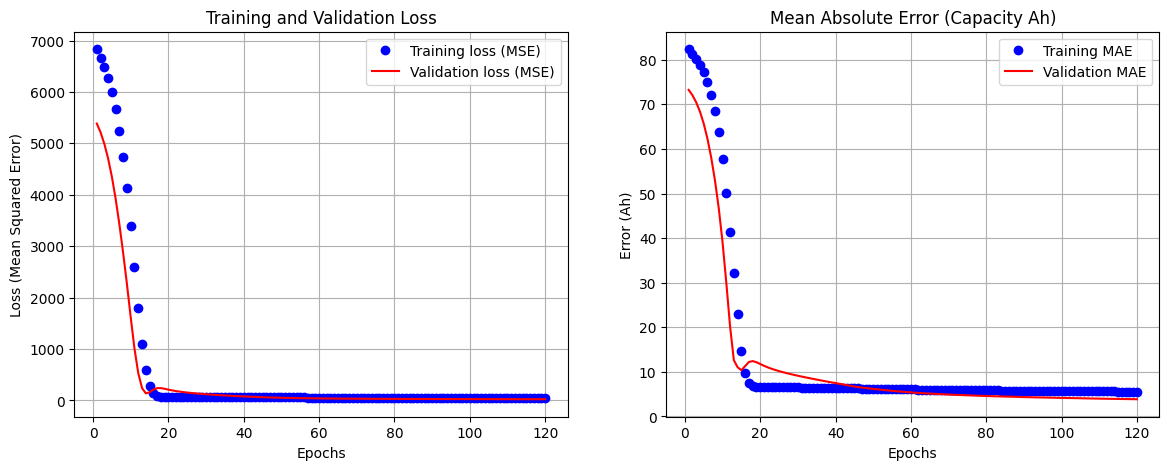

Final Training MAE: 5.5611
Final Validation MAE: 3.8687


In [7]:
import matplotlib.pyplot as plt

mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

# MSE
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss (MSE)')
plt.plot(epochs, val_loss, 'r', label='Validation loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Mean Absolute Error (Capacity Ah)')
plt.xlabel('Epochs')
plt.ylabel('Error (Ah)')
plt.legend()
plt.grid(True)

plt.show()

# Stampa finale numerica
print(f"Final Training MAE: {mae[-1]:.4f}")
print(f"Final Validation MAE: {val_mae[-1]:.4f}")

In [8]:
# port model on dongle
import emlearn

path = 'battery_soh_model.h'

cmodel = emlearn.convert(model, method='inline')

cmodel.save(file=path, name='battery_soh')

print('Wrote model to', path)

Wrote model to battery_soh_model.h
